In [1502]:
import csv, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq, ifft

speed = 2670 ## m/s
measured_thickness = [
5 + 38*0.02,
8 - 2*.02,
9 + 11*0.02] # 8.9?
measured_thickness

[5.76, 7.96, 9.22]

In [1503]:
def get_data(filename):
    with open(filename, 'r', encoding='cp1252') as file:
        lines = file.readlines()

    # 创建字典来存储参数
    parameters = {}

    # 逐行读取文件内容
    for line in lines:
        # 去除行首尾的空白符
        line = line.strip()
        # 忽略空行和注释行
        if not line or line.startswith('#'):
            continue
        # 如果行包含等号，则将其解析为键值对
        if '=' in line:
            key, value = line.split('=')
            parameters[key.strip()] = value.strip()

    # 读取数据表格
    ceps_data_start = False
    ascan_data_start = False
    spec_data_start = False
    # data = []

    for line in lines:
        if line.startswith("Distance"):
            ceps_data_start = True
            times, ceps = [], []
            continue
        elif line.startswith("Depth ["):
            times, hfs, amps = [], [], []
            ascan_data_start = True
            continue
        elif line.startswith("Frequency"):
            freqs, ffts = [], []
            spec_data_start = True
            continue
        if ascan_data_start and line.strip():
            # data.append(line.strip().split())
            time, hf, amp = line.strip().split()
            times.append(float(time))
            hfs.append(float(hf))
            amps.append(float(amp))
        if ceps_data_start and line.strip():
            time, cep = line.strip().split()
            times.append(float(time))
            ceps.append(float(cep))
        if spec_data_start and line.strip():
            freq, fft = line.strip().split()
            freqs.append(float(freq))
            ffts.append(float(fft))
    

    # # 打印参数
    # print("[front_panel] Parameters:")
    # for key, value in parameters.items():
    #     print(f"{key}: {value}")
    if ceps_data_start:
        times, ceps = np.array(times), np.array(ceps)
        return times, ceps
    elif ascan_data_start:
        times, hfs, amps = np.array(times), np.array(hfs), np.array(amps)
        return times, hfs, amps
    else:
        freqs, ffts = np.array(freqs), np.array(ffts)
        return freqs, ffts
    

In [1504]:
i = 1
times, ceps = get_data(os.getcwd()+f'/bulk{i}/bulk{i}_Ceps.dat')
atimes, hfs, amps = get_data(os.getcwd()+f'/bulk{i}/bulk{i}_Ascan.dat')
dt = np.average(np.diff(atimes))
freqs, ffts = get_data(os.getcwd()+f'/bulk{i}/bulk{i}_Spec.dat')
# times, ceps = get_data(os.getcwd()+'/bulk2_wrong/bulk2_Ceps.dat')

8.9534

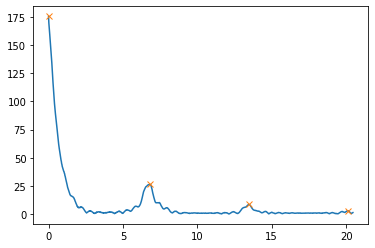

In [1505]:
peaks, _ = find_peaks(ceps, distance=3/dt)
peaks = np.concatenate(([0],peaks))
plt.plot(times,ceps)
plt.plot(ceps_peaks := times[peaks], ceps[peaks], 'x')
T_cep = np.average(np.diff(ceps_peaks)) * 1e-6
speed * T_cep/2 * 1e3

In [1506]:
# 畫 A-scan和cepstrum的圖比對！

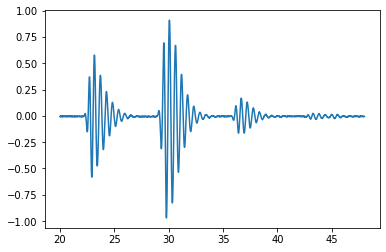

In [1507]:
fft_min, fft_max = 20., 48.

fft_range = np.where((atimes > fft_min)&(atimes < fft_max))
plt.plot(x:=atimes[fft_range], y:=hfs[fft_range])

4.9375928571428584

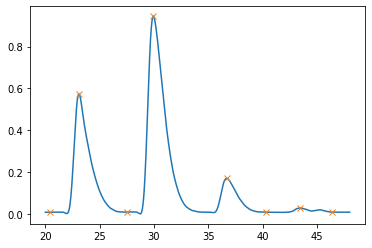

In [1508]:
plt.plot(atimes[fft_range], amps[fft_range])
peaks, _ = find_peaks(amps[fft_range], distance=2/dt)
plt.plot(atimes_peaks := atimes[fft_range][peaks], amps[fft_range][peaks], 'x')
T_ascan = np.average(np.diff(atimes_peaks))
T_ascan
speed*T_ascan*1e-6/2*1e3

9.089185135135136

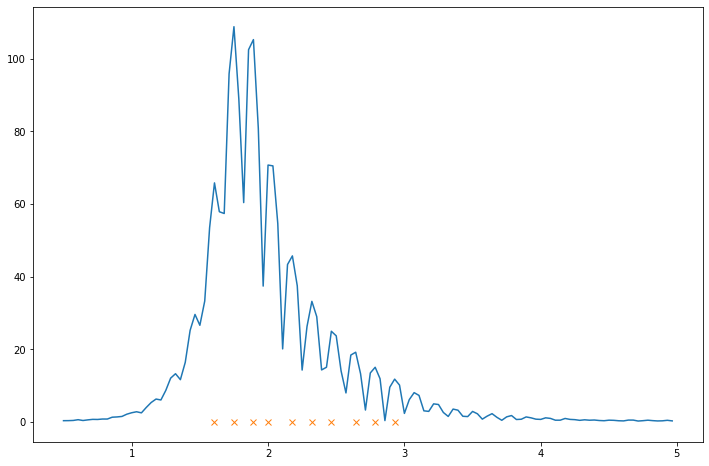

In [1509]:
yf = fft(y)
N = len(x)
xf = fftfreq(N, dt)

plt.figure(figsize=(12,8))
mask = np.where((xf>0.5)&(xf<5.))

plt.plot(xf[mask], (np.abs(yf[mask])))
peaks, _ = find_peaks(np.abs(yf), distance=1)

f_peaks = xf[peaks]
mask = np.where((f_peaks > 1.5) & (f_peaks < 3))
plt.plot(a:=f_peaks[mask], np.zeros_like(a),'x')
delta_f = np.average(np.diff(a))*1e6
T_spec = 1/delta_f
speed*T_spec/2*1e3

(0.0, 0.1)

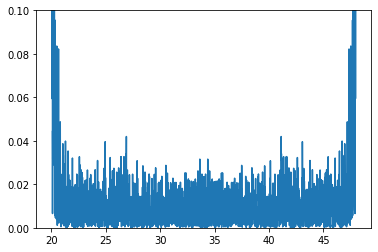

In [1510]:
plt.plot(atimes[fft_range],np.abs(ifft(np.log(np.abs(yf)))))
plt.ylim(0,0.1)